In [1]:
import numpy as np
import pandas as pd
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import matplotlib
from matplotlib import pyplot as plt

### Load 10x Data

In [2]:
W_DIR = '/project/GCRB/Hon_lab/s425140/Tutorial/00.Mapping/DAA93_10x/outs/'

In [3]:
mtx = sc.read_10x_h5(W_DIR + 'filtered_feature_bc_matrix.h5', gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
mtx.obs

""
AAACCCAAGCGTGCTC-1
AAACCCAAGTGAGGCT-1
AAACCCAAGTGGGAAA-1
AAACCCAAGTGTTGAA-1
AAACCCACATAACTCG-1
...
TTTGTTGGTACTGCGC-1
TTTGTTGGTCATAACC-1
TTTGTTGGTCCACGCA-1
TTTGTTGGTCTTGCTC-1


### Uniq variables and save raw data

In [4]:
mtx.var_names_make_unique()
mtx.raw = mtx

### Processing

In [5]:
#merget gene index
c_num, g_num = mtx.X.shape

all_singlet_idx = np.asarray(mtx.obs.index)


#get the high mito cells
mt_index = mtx.var.index[mtx.var.index.str.startswith('MT-')].tolist()
mt_expr = np.sum(mtx[:,mt_index].X, axis=1)
depth = np.sum(mtx.X, axis=1)
high_mito_idx = np.argwhere((mt_expr / depth) > 0.6)[:,0].squeeze()

#get the gene and cell index
chosen_cell_index = np.setdiff1d(all_singlet_idx, all_singlet_idx[high_mito_idx])

#filter the matrix
adata_filtered = mtx[chosen_cell_index, :]

#use recipe from Zheng et al
sc.pp.recipe_zheng17(adata_filtered, n_top_genes = 1000)

Trying to set attribute `.var` of view, copying.


Text(0.5, 0, 'Mito Gene Expr (log10)')

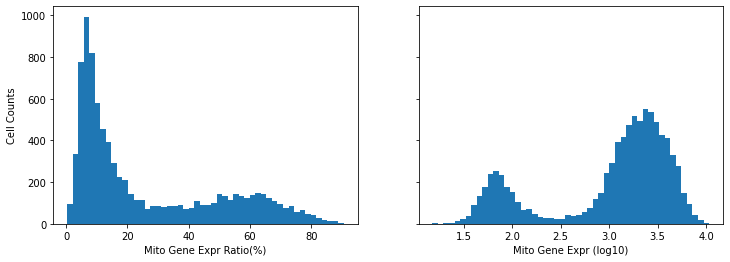

In [6]:
## check the mito gene expr
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4), sharey=True)
ax1.hist(mt_expr / depth * 100, bins=50)
ax1.set_xlabel('Mito Gene Expr Ratio(%)')
ax1.set_ylabel('Cell Counts')

ax2.hist(np.log10(mt_expr+0.1), bins=50)
ax2.set_xlabel('Mito Gene Expr (log10)')

### Perform Dimension reduction analysis

In [7]:
sc.tl.pca(adata_filtered)

In [8]:
sc.pp.neighbors(
    adata_filtered,
    use_rep='X_pca'
)

In [9]:
sc.tl.louvain(
    adata_filtered,
    resolution=0.50)

In [10]:
sc.tl.paga(
    adata_filtered,
    groups='louvain'
)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


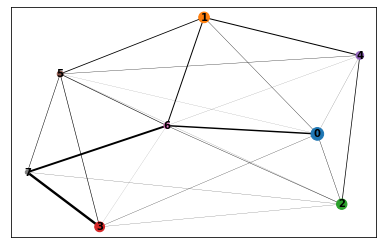

In [11]:
sc.pl.paga(
    adata_filtered, 
    color=['louvain'], 
    use_raw=True,
    layout='fr',
    threshold=0.01,
    node_size_scale=0.5,
    node_size_power=0.9,
)

### TSNE

In [12]:
sc.tl.tsne(
    adata_filtered)

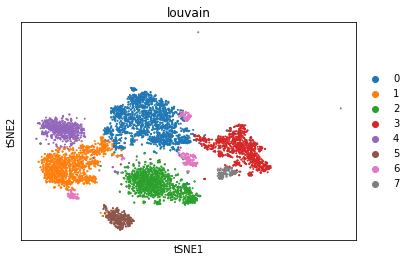

In [13]:
sc.pl.tsne(
    adata_filtered,
    color = ['louvain'])

### UMAP 

In [14]:
sc.tl.umap(
    adata_filtered,
    init_pos='paga',
)

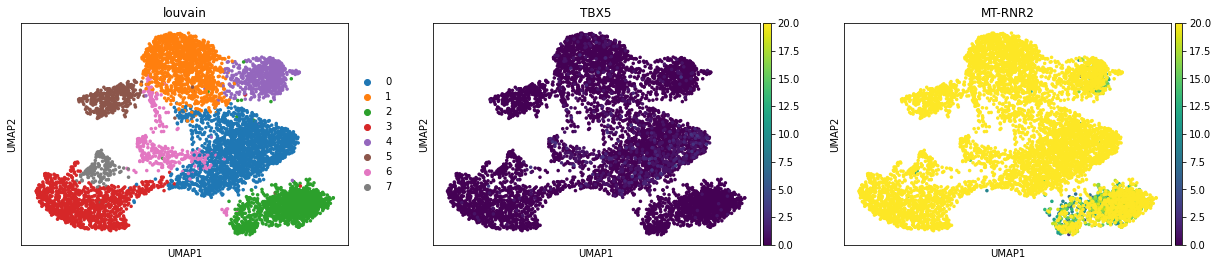

In [15]:
sc.pl.umap(
    adata_filtered, 
    color=['louvain', 'TBX5', 'MT-RNR2'],
        size=50,
            use_raw=True,
    vmin=0, vmax=20,
)

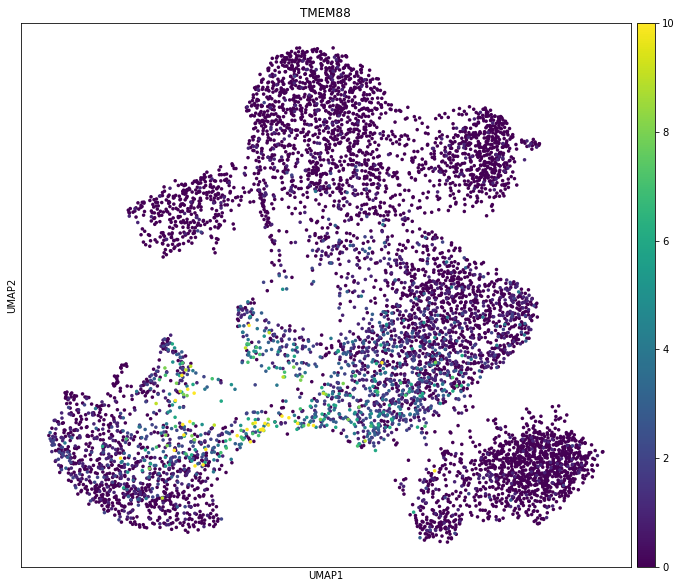

In [16]:
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.umap(
    adata_filtered, 
    color=['TMEM88'],
        size=50,
            use_raw=True,
    ax=ax,
    vmin=0, vmax=10,
)

### Find genes enriched in each cluster

In [17]:
sc.tl.rank_genes_groups(adata_filtered, groupby='louvain', method='wilcoxon')

/home2/s425140/.conda/envs/practice/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:413: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(means[imask]) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


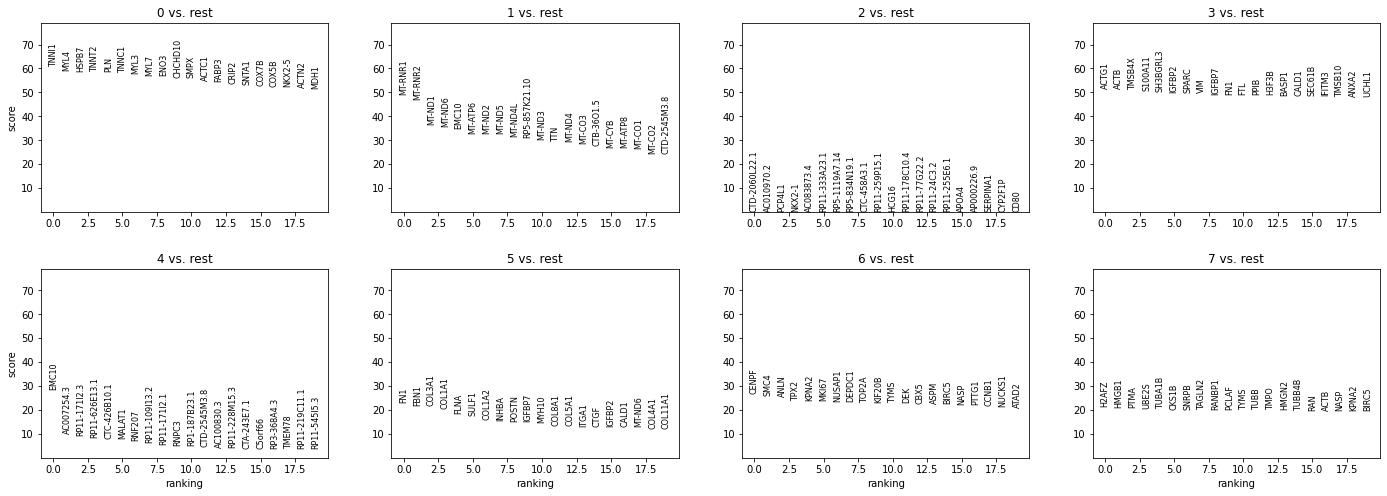

In [18]:
sc.pl.rank_genes_groups(adata_filtered)

### Heatmaps

In [19]:
markers = adata_filtered.uns['rank_genes_groups']['names'][1]
marks = []
for x in markers:
    marks.append(x)

In [20]:
marks

['MYL4',
 'MT-RNR2',
 'AC010970.2',
 'ACTB',
 'AC007254.3',
 'FBN1',
 'SMC4',
 'HMGB1']

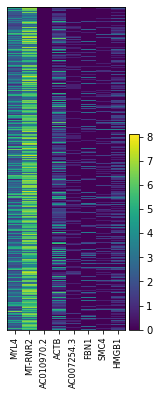

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0, 2.4, 0, 0.2])

In [21]:
sc.pl.heatmap(adata_filtered, marks, log = True)

### Violin Plot

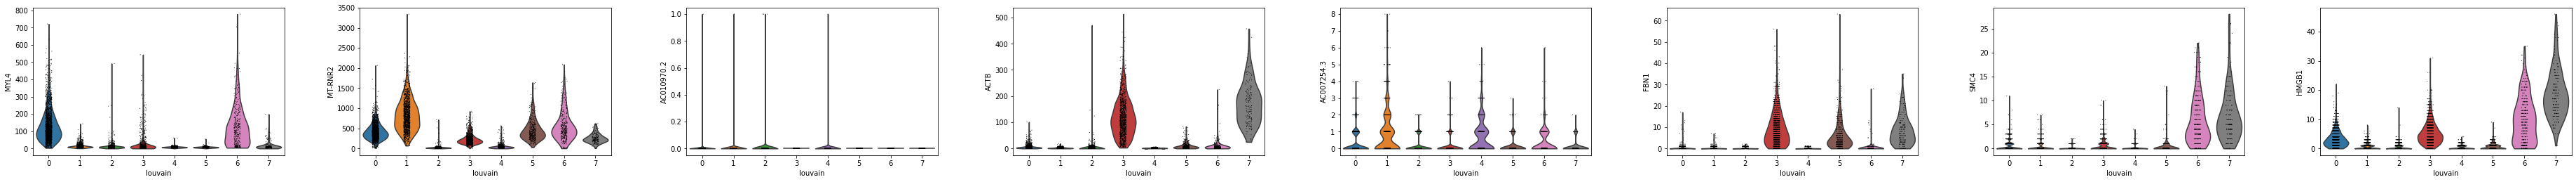

In [22]:
sc.pl.violin(adata_filtered, keys= marks, groupby='louvain', log = False)

### Save adata matrix/analysis

In [23]:
adata_filtered.write('./practice.h5ad')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


### Load adata matrix

In [24]:
potato = sc.read('./practice.h5ad')

In [25]:
adata_filtered.X[2,2]

-0.018791828

In [26]:
adata_filtered.obs

,n_counts_all,louvain
AAACCCAAGCGTGCTC-1,845.0,2
AAACCCAAGTGAGGCT-1,814.0,2
AAACCCAAGTGGGAAA-1,1578.0,4
AAACCCAAGTGTTGAA-1,17262.0,0
AAACCCACATAACTCG-1,2997.0,4
...,...,...
TTTGTTGCACAACGAG-1,11931.0,0
TTTGTTGCATGGAGAC-1,11607.0,1
TTTGTTGGTACTGCGC-1,1438.0,2
TTTGTTGGTCCACGCA-1,14541.0,6
